In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.integrate as integrate
##
from util import tools

In [2]:
plt.rcParams['figure.figsize'] = (16, 4.5)
plt.style.use('seaborn-whitegrid')

In [3]:
path = './util/datastore/yield_italy_daily_2010_2020.xlsx'
data = tools.load_BTP_curve(path)
data = data
diff_r = data.diff()[1:]

In [4]:
tenors = np.array(data.columns.values)

In [5]:
sigma = diff_r.cov()
sigma *= 252 # annualized
print("Sigma shape : " + str(sigma.shape))

Sigma shape : (12, 12)


### Volatility Fitting
The eigenvectors of the Covariance matrix are actually the directions of the axes where there is the most variance(most information) and that we call Principal Components. And eigenvalues are simply the coefficients attached to eigenvectors, which give the amount of variance carried in each Principal Component.


#### PCA and Eigendecomposition
<ul>
<li>Obtain the Eigenvectors and Eigenvalues from the covariance matrix $\Sigma^{d\times d}$ </li>
<li>Sort eigenvalues in descending order and choose the $k$ eigenvectors that correspond to the k largest eigenvalues where $k$ is the number of dimensions of the new feature subspace $(k≤d)$.</li>
<li>Construct the projection matrix $\pmb{W}^{dxk}$ from the selected $k$ eigenvectors.</li>
<li> Transform the original dataset $\pmb{X}$ via $\pmb{W}$ to obtain a k-dimensional feature subspace Y.

</ul>

In [6]:
eigval, eigvec = np.linalg.eig(sigma)
factors = 3

In [7]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eigval[i]), eigvec[:,i]) for i in range(len(eigval))]
eig_pairs.sort(key=lambda x: x[0], reverse=True)
print('Eigenvalues in descending order:')
for i in eig_pairs[:5]:
    print(i[0])

Eigenvalues in descending order:
0.002065832029113486
0.0001320181991700513
2.8182781875024407e-05
1.2136380106650938e-05
9.53767974856639e-06


In [8]:
print("Highest Eigenvalues:")
print(eigval[:3])

Highest Eigenvalues:
[2.06583203e-03 1.32018199e-04 2.81827819e-05]


In [9]:
tot = sum(eigval) # la somma degli autovettori è la varianza totale
var_exp = [(i / tot)*100 for i in sorted(eigval, reverse=True)]
cum_var_explained = np.cumsum(var_exp)

In [10]:
print("Variance% explained by the first 3 Eigenvectors:")
print(cum_var_explained[2])

Variance% explained by the first 3 Eigenvectors:
97.86240809997076


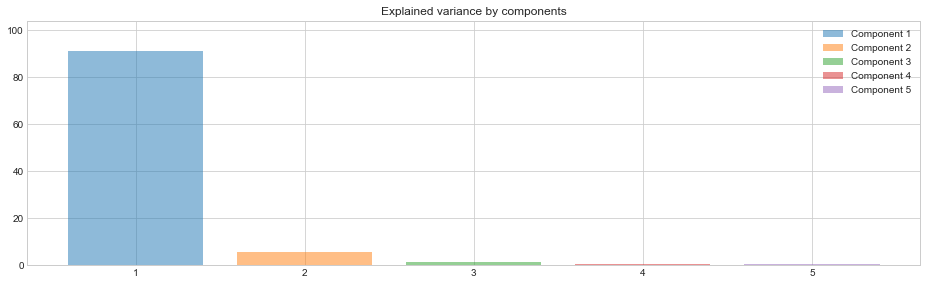

In [11]:
[plt.bar(i +1, var_exp[i], alpha = 0.5, label = ("Component " + str(i +1))) for i in range(0,5)]
[plt.step(i+1, cum_var_explained[i]) for i in range(0,5)]
plt.title("Explained variance by components")
plt.legend()
plt.show()

 Construction of the projection matrix that will be used to transform the original data onto the new feature subspace. Reducing the d-dimensional tenor space to a k-dimensional tenor subspace, by choosing the top $k$ eigenvectors with the highest eigenvalues to construct our $d×k$ dimensional eigenvector matrix $\pmb{W}^{d \times k}$.

$$\pmb{Y}^{n \times k} = \pmb{X}^{n \times d} \times \pmb{W}^{d \times k}$$

Where $d$ is the BTP tenor, $n$ is the observation date and $k$ the number of principal components

In [12]:
nfactors = 3
princ_eigvector = [eig_pairs[i][1] for i in range(0,nfactors)]
princ_eigvalues = [eig_pairs[i][0] for i in range(0,nfactors)]
W_matrix = np.vstack(princ_eigvector).T 

In [13]:
Y = data.dot(W_matrix)

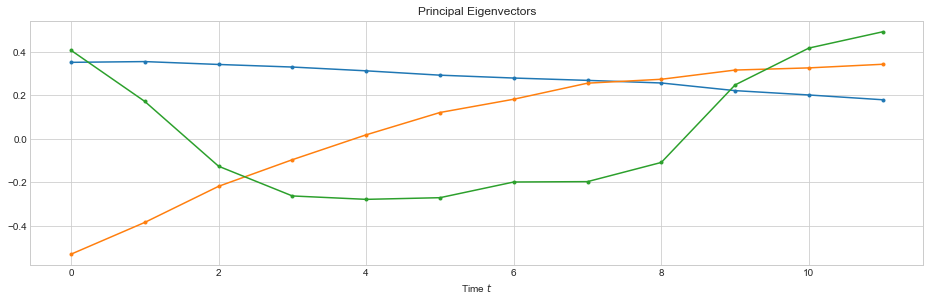

In [14]:
plt.plot(W_matrix, marker='.'), plt.title('Principal Eigenvectors'), plt.xlabel(r'Time $t$');

**Get volatility:** <br>
What is the norm that was used to scale the eigenvector? It is the square root of the sum of squares of the coefficicents in the vector, i.e. the square root of the variance. The eigenvalue is the square of this value, i.e. it is the sum of squares = total variance.<br>
https://stats.stackexchange.com/questions/346692/how-does-eigenvalues-measure-variance-along-the-principal-components-in-pca#:~:text=The%20eigenvalue%20is%20the%20square,sum%20of%20squares%20%3D%20total%20variance.&text=Then%20the%20scores%2C%20since%20they,data%20by%20each%20unit%20vector.

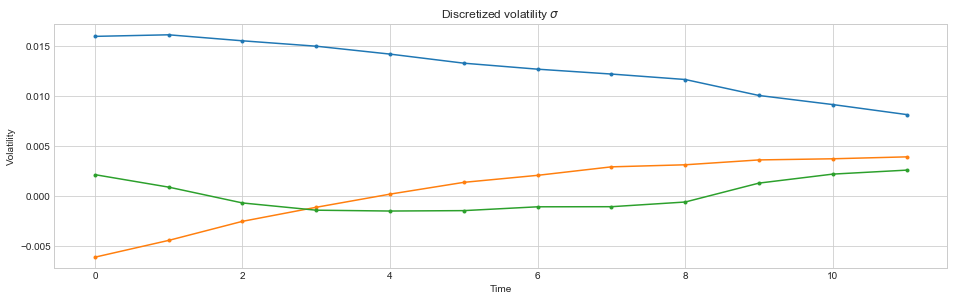

In [15]:
vol_compressed = np.sqrt(princ_eigvalues)*W_matrix 
plt.plot(vol_compressed, marker = '.'), plt.xlabel("Time"), plt.ylabel('Volatility')
plt.title("Discretized volatility $\sigma$")
plt.show()

**Volatility fitting** <br>
The $1^{st}$ principal component is approximated with a straigth line, the $2^{nd}$ and $3^{rd}$ with a $3^{rd}$ degree polynomial:

In [16]:
def interp_volatility(vols, tenors):
    """
    Parameters
    -------
    vols: compressed volatility matrix to be interpolated (nObs x nFactors)
    tenors: array of tenors used for fitting
    Returns
    -------
    x: Volatility fitted polynomials
    save_pmts: polynomials weigths
    """
    x = np.zeros((vols.shape[0], vols.shape[1]))
    degree = 2
    save_pmts = []
    for i in range(0, vols.shape[1]):
        vol = np.array(vols[:,i].flatten())
        fit_vol = np.polyfit(x = tenors, y = vol, deg = degree)
        x[:,i] = np.polyval(fit_vol, tenors)
        degree = 4
        save_pmts.append(fit_vol)
    return x, save_pmts

In [17]:
fitted_vol, rg = interp_volatility(vol_compressed, tenors)

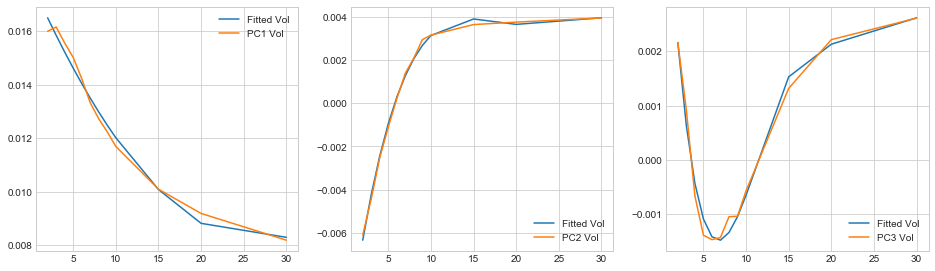

In [18]:
plt.subplot(1, 3, 1), plt.plot(tenors, fitted_vol[:,0]), plt.plot(tenors, vol_compressed[:, 0])
plt.legend(["Fitted Vol", "PC1 Vol"])
plt.subplot(1, 3, 2), plt.plot(tenors, fitted_vol[:,1]), plt.plot(tenors, vol_compressed[:, 1])
plt.legend(["Fitted Vol", "PC2 Vol"])
plt.subplot(1, 3, 3), plt.plot(tenors, fitted_vol[:,2]), plt.plot(tenors, vol_compressed[:, 2])
plt.legend(["Fitted Vol", "PC3 Vol"])
plt.show()

In [19]:
# prova integrale numerico
test = np.poly1d(rg[0]) # funzione del primo componente
prova = integrate.quad(test, a = 1, b = 10)[0]
prova

0.12977741560729616

### Gaussian HJM
Under the risk neutral measure $\mathbb{Q}$ the instantaneous forward rate process is:
$$df(t, T) = \sigma_f(t, T)^\top \sigma_P(t, T)dt + \sigma_f (t, T)^\top dW (t) $$
that can be rewritten as (pg 495 pdf Andersen-Piterbarg):
$$df(t, T) = \sigma_f(t, T)^\top \int_t^T\sigma_f(t, u)du dt + \sigma_f (t, T)^\top dW (t) $$
with $\sigma_f$ being a d-dimensional vector.

#### Risk Neutral drift 
Now use the fitted polynomial to define $\sigma_f$, the drift $\mu(t,\tau)$ is calculated using numerical integration over that function <br><br>
$$df(t, T) = \mu(t,T)dt $$
$$ \mu(t,T) = \sum_{i=1}^n \sigma_f(t,T) \int_t^T \sigma_f(t,u)du  $$

In [20]:
vol_functions = [np.poly1d(coeff) for coeff in rg]

# t = 0 
def mu(T, vol_functions):
    mean = 0
    for sigma in vol_functions:
        comp_mean = integrate.quad(sigma, 0, T)[0] * sigma(T)
        mean += comp_mean
    return mean

In [21]:
simulation_tenors = np.linspace(0,25,12)
simulation_drift = [mu(T, vol_functions) for T in simulation_tenors]
simulation_vols = fitted_vol

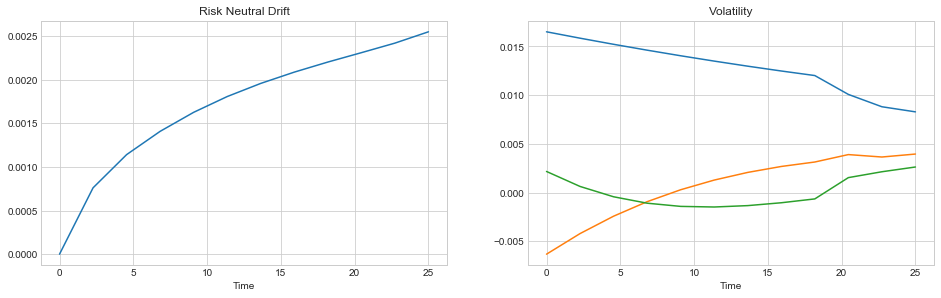

In [22]:
plt.subplot(1,2,1), plt.plot(simulation_tenors, simulation_drift), plt.xlabel("Time")
plt.title("Risk Neutral Drift")
plt.subplot(1,2,2), plt.plot(simulation_tenors, simulation_vols), plt.xlabel("Time")
plt.title("Volatility")
plt.show()